<a href="https://colab.research.google.com/github/BrauuHdzM/Clasificacion-imagenes-MobileNetV2/blob/master/Modelo_DaVinci_Binario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/drive/MyDrive/DaVincis/Violent | wc -l
!ls /content/drive/MyDrive/DaVincis/NonViolent | wc -l


1276
1713


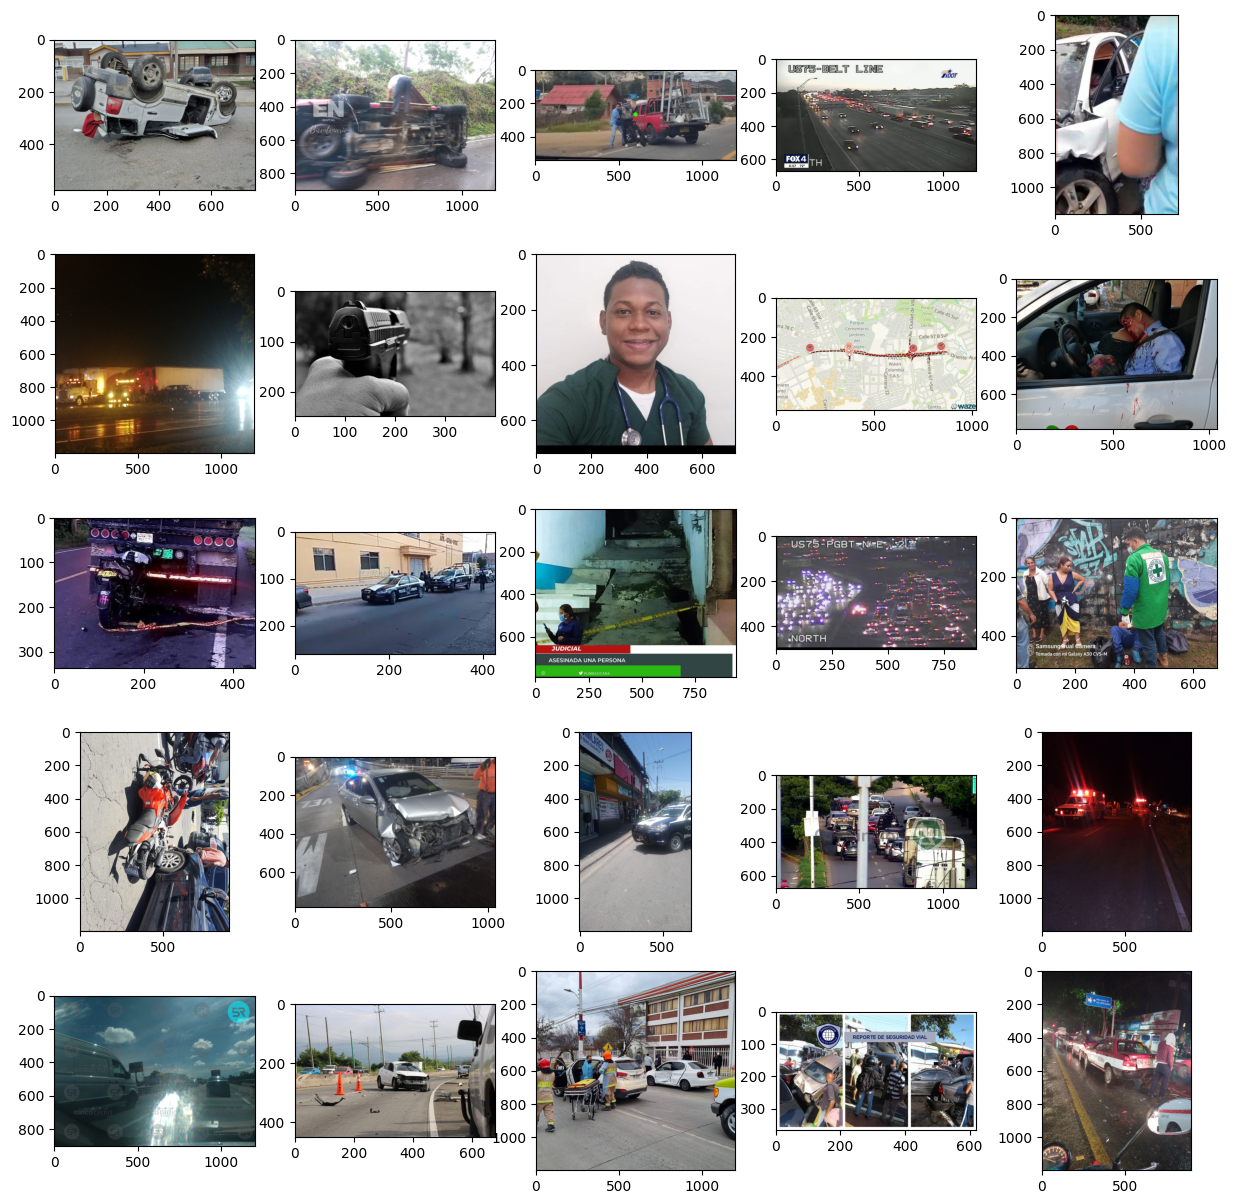

In [ ]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/drive/MyDrive/DaVincis/Violent'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [ ]:
#Crear carpetas para hacer el set de datos

!mkdir dataset
!mkdir dataset/Violent
!mkdir dataset/NonViolent

In [ ]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 419 (el num. menor de imagenes que subi)

import shutil
carpeta_fuente = '/content/drive/MyDrive/DaVincis/Violent'
carpeta_destino = '/content/dataset/Violent'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 1250:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
carpeta_fuente = '/content/drive/MyDrive/DaVincis/NonViolent'
carpeta_destino = '/content/dataset/NonViolent'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 1250:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls /content/dataset/Violent | wc -l
!ls /content/dataset/NonViolent | wc -l

1250
1250


Found 2250 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


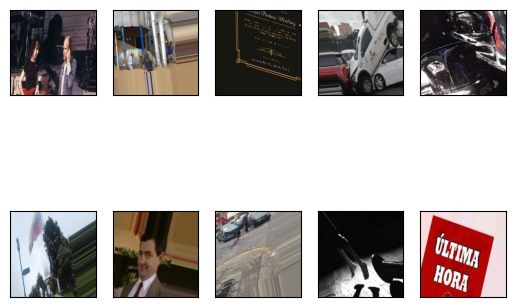

In [ ]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.1 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [ ]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [ ]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Entrenar el modelo
EPOCAS = 70

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/70
20/71 [=======>......................] - ETA: 40s - loss: 0.7152 - accuracy: 0.6203

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


71/71 [==============================] - 78s 925ms/step - loss: 0.6295 - accuracy: 0.6871 - val_loss: 0.6629 - val_accuracy: 0.6880
Epoch 2/70
71/71 [==============================] - 65s 920ms/step - loss: 0.5403 - accuracy: 0.7533 - val_loss: 0.7505 - val_accuracy: 0.6760
Epoch 3/70
71/71 [==============================] - 67s 948ms/step - loss: 0.5134 - accuracy: 0.7667 - val_loss: 0.5836 - val_accuracy: 0.7200
Epoch 4/70
71/71 [==============================] - 64s 897ms/step - loss: 0.5117 - accuracy: 0.7689 - val_loss: 0.5669 - val_accuracy: 0.7440
Epoch 5/70
71/71 [==============================] - 65s 909ms/step - loss: 0.4707 - accuracy: 0.7916 - val_loss: 0.5910 - val_accuracy: 0.7080
Epoch 6/70
71/71 [==============================] - 65s 910ms/step - loss: 0.4707 - accuracy: 0.7831 - val_loss: 0.6363 - val_accuracy: 0.7200
Epoch 7/70
71/71 [==============================] - 67s 949ms/step - loss: 0.4679 - accuracy: 0.7840 - val_loss: 0.5893 - val_accuracy: 0.7240
Epoch 8/70

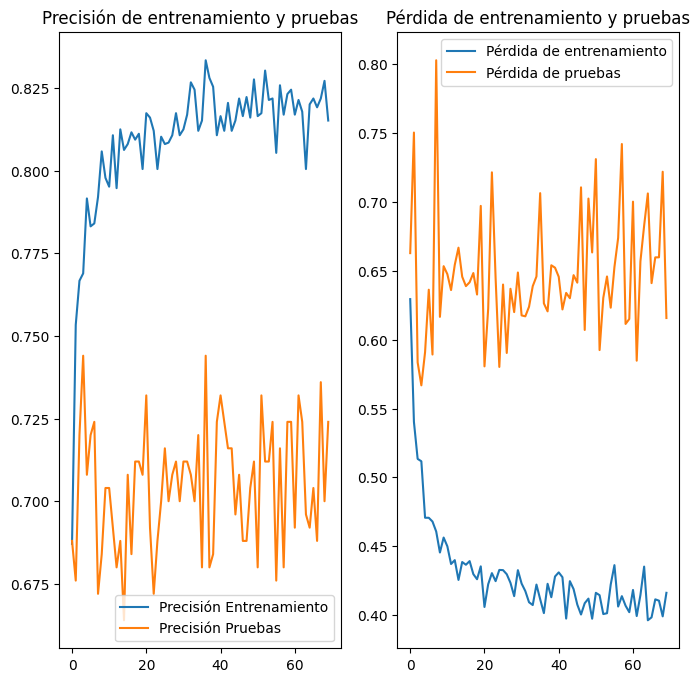

In [ ]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(70)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [ ]:
modelo.save('/content/my_saved_model')

In [ ]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modeloBin.zip /content/my_saved_model

  adding: content/my_saved_model/ (stored 0%)
  adding: content/my_saved_model/assets/ (stored 0%)
  adding: content/my_saved_model/keras_metadata.pb (deflated 80%)
  adding: content/my_saved_model/saved_model.pb (deflated 92%)
  adding: content/my_saved_model/fingerprint.pb (stored 0%)
  adding: content/my_saved_model/variables/ (stored 0%)
  adding: content/my_saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_saved_model/variables/variables.index (deflated 78%)


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/my_saved_model')
# Obtener la firma predeterminada del modelo
inference_func = loaded_model.signatures["serving_default"]